ROI掩码形状: (868, 782)
ROI像素数量: 407220
2023年表征形状: (868, 782, 128)
2024年表征形状: (868, 782, 128)
正在标准化嵌入向量...
计算点积...


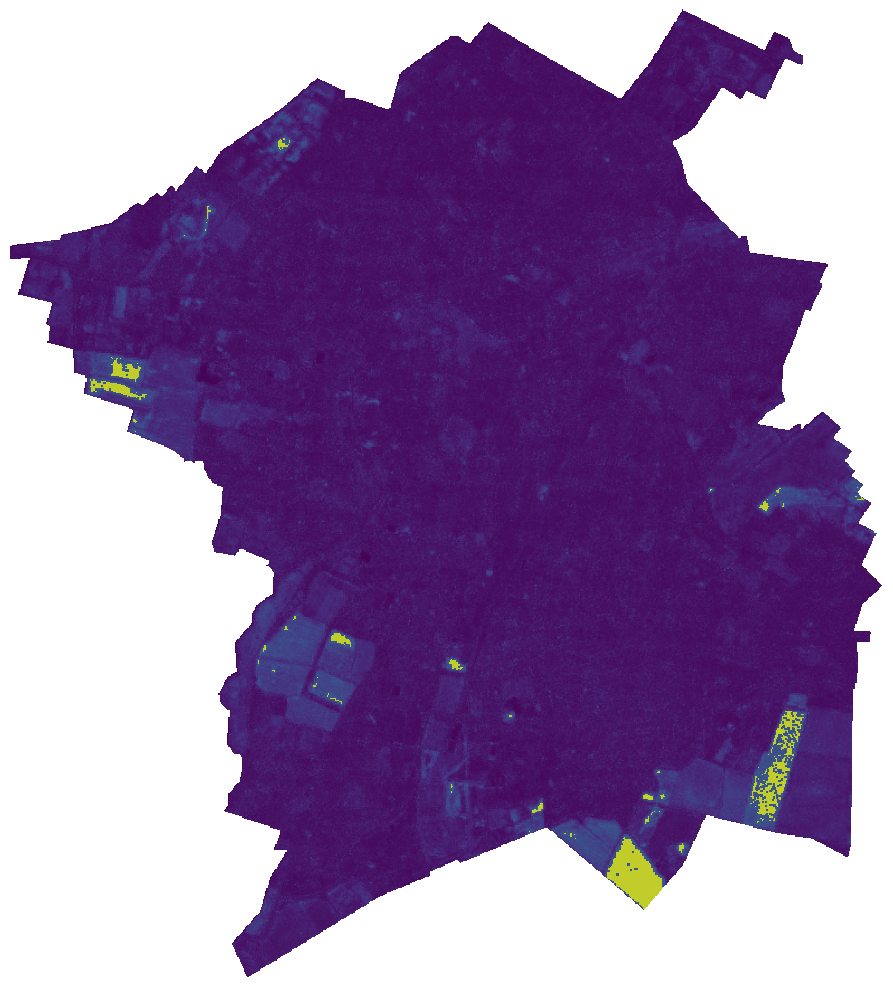

变化检测图已保存为: cambridge_change_detection_2023_2024_roi.png
ROI内具有显著变化的区域百分比: 1.50%
ROI总像素数: 407220
变化像素数: 6119

ROI内变化值统计:
最小值: 0.0012
最大值: 0.9079
平均值: 0.1244
标准差: 0.0967
中位数: 0.0938

分析完成！


<Figure size 640x480 with 0 Axes>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio

year1 = 2023
year2 = 2024

# 加载ROI掩码
with rasterio.open('/mnt/e/Codes/btfm4rs/data/downstream/cambridge/cambridge.tiff') as src:
    roi_mask = src.read(1).astype(bool)  # 转换为布尔掩码

print(f"ROI掩码形状: {roi_mask.shape}")
print(f"ROI像素数量: {np.sum(roi_mask)}")

# 加载2019和2020年的numpy文件
embedding1 = np.load(f'/mnt/e/Codes/btfm4rs/data/downstream/cambridge/{year1}_fsdp_20250407_195912.npy')
embedding2 = np.load(f'/mnt/e/Codes/btfm4rs/data/downstream/cambridge/{year2}_fsdp_20250407_195912.npy')

# 打印形状以验证
print(f"{year1}年表征形状: {embedding1.shape}")
print(f"{year2}年表征形状: {embedding2.shape}")

# 将嵌入向量标准化为单位长度，只对ROI内的像素进行归一化
def normalize_embeddings_with_mask(embeddings, mask):
    """
    对嵌入向量进行归一化，只处理ROI内的像素
    
    Args:
        embeddings: 输入的嵌入向量数组，形状为 (h, w, c)
        mask: ROI掩码，形状为 (h, w)
    
    Returns:
        归一化后的嵌入向量，ROI外的像素保持为零
    """
    # 获取形状参数
    h, w, c = embeddings.shape
    
    # 创建输出数组，初始化为零
    normalized = np.zeros_like(embeddings)
    
    # 只处理ROI内的像素
    roi_pixels = embeddings[mask]  # 形状为 (num_roi_pixels, c)
    
    # 计算每个向量的幅度
    magnitudes = np.sqrt(np.sum(roi_pixels**2, axis=1, keepdims=True))
    
    # 对每个向量进行标准化(避免除以零)
    normalized_roi = np.divide(roi_pixels, magnitudes, out=np.zeros_like(roi_pixels), where=magnitudes!=0)
    
    # 将归一化后的值放回原位置
    normalized[mask] = normalized_roi
    
    return normalized

# 标准化嵌入向量
print("正在标准化嵌入向量...")
normalized1 = normalize_embeddings_with_mask(embedding1, roi_mask)
normalized2 = normalize_embeddings_with_mask(embedding2, roi_mask)

# 计算对应像素之间的点积，只在ROI内计算
print("计算点积...")
dot_product = np.zeros(roi_mask.shape)
dot_product[roi_mask] = np.sum(normalized1[roi_mask] * normalized2[roi_mask], axis=1)

# 按照参考资料中的建议重新缩放结果:
# 1. 乘以-1翻转比例(这样变化接近1，无变化接近-1)
# 2. 加1以将范围从-1到1重新缩放为0到2
rescaled_change = np.zeros_like(dot_product)
rescaled_change[roi_mask] = (dot_product[roi_mask] * -1) + 1

# 现在，接近0的值表示变化小，接近2的值表示变化显著

# 创建显著变化区域的掩码(根据需要调整阈值)
change_threshold = 0.5  # 需要根据数据调整此阈值
change_mask = (rescaled_change > change_threshold) & roi_mask

# 可视化变化图
plt.figure(figsize=(12, 10))

# 创建用于显示的掩码数组，ROI外部设为NaN以实现透明效果
display_change = np.full_like(rescaled_change, np.nan)
display_change[roi_mask] = rescaled_change[roi_mask]

# 绘制基本变化图
plt.imshow(display_change, cmap='viridis', vmin=0, vmax=2)
# cbar = plt.colorbar(label='Change Magnitude (0=No Change, 2=Significant Change)')

# 创建自定义颜色映射：透明表示无变化，黄色表示变化
colors = [(1, 1, 1, 0), (1, 1, 0, 1)]  # 从透明到黄色
cmap_overlay = LinearSegmentedColormap.from_list('change_cmap', colors, N=256)

# 创建用于叠加的掩码
overlay_mask = np.full_like(change_mask, np.nan, dtype=float)
overlay_mask[change_mask] = 1.0

# 使用黄色叠加变化掩码
plt.imshow(overlay_mask, cmap=cmap_overlay, vmin=0, vmax=1, alpha=0.7)

# plt.title(f'{year1}-{year2} Dot Product Change Map (ROI Only)')
plt.axis('off')
plt.tight_layout()
plt.show()

# 保存图形
plt.savefig(f'cambridge_change_detection_{year1}_{year2}_roi.png', dpi=300, bbox_inches='tight')
print(f"变化检测图已保存为: cambridge_change_detection_{year1}_{year2}_roi.png")

# 额外分析：计算变化的一些统计数据
roi_pixels_count = np.sum(roi_mask)
change_pixels_count = np.sum(change_mask)
change_percentage = change_pixels_count / roi_pixels_count * 100
print(f"ROI内具有显著变化的区域百分比: {change_percentage:.2f}%")
print(f"ROI总像素数: {roi_pixels_count}")
print(f"变化像素数: {change_pixels_count}")

# 打印变化值的统计信息
print(f"\nROI内变化值统计:")
print(f"最小值: {np.min(roi_change_values):.4f}")
print(f"最大值: {np.max(roi_change_values):.4f}")
print(f"平均值: {np.mean(roi_change_values):.4f}")
print(f"标准差: {np.std(roi_change_values):.4f}")
print(f"中位数: {np.median(roi_change_values):.4f}")
print("\n分析完成！")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import imageio.v2 as imageio
import os
from tqdm import tqdm
import rasterio  # For reading the TIFF file

# Base year for comparison
base_year = 2017
# Years to compare with the base year
comparison_years = range(2018, 2025)  # 2018 to 2024

# Define output directory for temporary images
output_dir = 'change_detection_frames'
os.makedirs(output_dir, exist_ok=True)

# 加载ROI掩码（二值TIFF）
def load_roi_mask():
    print("Loading ROI mask...")
    with rasterio.open('/mnt/e/Codes/btfm4rs/data/downstream/cambridge/cambridge.tiff') as src:
        mask = src.read(1)  # Read the first band
        # 确保掩码是二值的（1表示有效区域，0表示无效区域）
        mask = mask > 0
    return mask

# 将嵌入向量标准化为单位长度
def normalize_embeddings(embeddings):
    h, w, c = embeddings.shape
    reshaped = embeddings.reshape(-1, c)
    magnitudes = np.sqrt(np.sum(reshaped**2, axis=1, keepdims=True))
    normalized = np.divide(reshaped, magnitudes, out=np.zeros_like(reshaped), where=magnitudes!=0)
    return normalized.reshape(h, w, c)

# 计算两年之间的变化
def compute_change(year1, year2):
    # 加载数据
    print(f"Loading embeddings for {year1} and {year2}...")
    emb1 = np.load(f'/mnt/e/Codes/btfm4rs/data/downstream/cambridge/{year1}_fsdp_20250407_195912.npy')
    emb2 = np.load(f'/mnt/e/Codes/btfm4rs/data/downstream/cambridge/{year2}_fsdp_20250407_195912.npy')
    
    # 标准化
    print(f"Normalizing embeddings...")
    norm1 = normalize_embeddings(emb1)
    norm2 = normalize_embeddings(emb2)
    
    # 计算点积和重新缩放
    print(f"Computing dot product and rescaling...")
    dot_prod = np.sum(norm1 * norm2, axis=2)
    rescaled = (dot_prod * -1) + 1
    
    return rescaled

# 生成并保存单个变化图
def generate_change_map(year1, year2, roi_mask, change_threshold=0.5, save_path=None):
    # 计算变化
    rescaled_change = compute_change(year1, year2)
    
    # 确保ROI掩码与变化数据形状匹配
    if roi_mask.shape != rescaled_change.shape:
        print(f"Warning: ROI mask shape {roi_mask.shape} doesn't match change data shape {rescaled_change.shape}")
        # 尝试调整大小或裁剪掩码以匹配变化数据
        if roi_mask.shape[0] >= rescaled_change.shape[0] and roi_mask.shape[1] >= rescaled_change.shape[1]:
            roi_mask = roi_mask[:rescaled_change.shape[0], :rescaled_change.shape[1]]
        else:
            # 如果掩码太小，创建一个新的相同大小的掩码，并填充可用数据
            new_mask = np.zeros(rescaled_change.shape, dtype=bool)
            h, w = min(roi_mask.shape[0], rescaled_change.shape[0]), min(roi_mask.shape[1], rescaled_change.shape[1])
            new_mask[:h, :w] = roi_mask[:h, :w]
            roi_mask = new_mask
    
    # 创建变化掩码
    change_mask = rescaled_change > change_threshold
    
    # 将变化掩码与ROI掩码结合（只在ROI内显示变化）
    combined_mask = change_mask & roi_mask
    
    # 可视化变化图
    plt.figure(figsize=(12, 10))
    
    # 创建自定义颜色映射：透明表示无变化或非ROI区域，黄色表示有变化的区域
    colors = [(1, 1, 1, 0), (1, 1, 0, 1)]  # 从透明到黄色
    change_cmap = LinearSegmentedColormap.from_list('change_cmap', colors, N=256)
    
    # 创建一个用于rescaled_change的colormap，但ROI外的区域为透明
    # 首先创建带有alpha通道的viridis colormap
    viridis = plt.cm.viridis
    viridis_colors = viridis(np.linspace(0, 1, 256))
    viridis_colors[:, 3] = np.linspace(0, 1, 256)  # 设置alpha通道
    masked_viridis = LinearSegmentedColormap.from_list('masked_viridis', viridis_colors)
    
    # 创建一个掩码版本的rescaled_change，非ROI区域设置为NaN（将被渲染为透明）
    masked_change = np.copy(rescaled_change)
    masked_change[~roi_mask] = np.nan
    
    # 绘制掩码后的基本变化图
    plt.imshow(masked_change, cmap=masked_viridis, vmin=0, vmax=2)
    
    # 使用黄色叠加变化掩码（仅在ROI内部）
    plt.imshow(np.ma.masked_where(~combined_mask, combined_mask), cmap=change_cmap, vmin=0, vmax=1)
    
    # 只显示标题，没有颜色条
    plt.title(f'{year1}-{year2}', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    
    # 保存图形，确保支持透明度
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
        plt.close()
        return save_path
    else:
        plt.show()
        plt.close()
        return None

# 生成所有年份对比的变化图并创建GIF
def generate_change_detection_gif(base_year, comparison_years, roi_mask, output_gif='cambridge_change_detection_roi.gif', frame_duration=2):
    # 保存每个帧的文件路径
    frame_paths = []
    
    # 生成每一帧
    print("Generating frames for GIF animation...")
    for year in tqdm(comparison_years):
        frame_path = os.path.join(output_dir, f'change_{base_year}_{year}_roi.png')
        generate_change_map(base_year, year, roi_mask, save_path=frame_path)
        frame_paths.append(frame_path)
    
    # 创建GIF - 确保每一帧显示2秒
    print(f"Creating GIF animation: {output_gif}...")
    
    # 读取所有图像
    images = []
    for frame_path in frame_paths:
        images.append(imageio.imread(frame_path))
    
    # 使用imageio v2 API创建GIF，确保每一帧显示的时间为frame_duration秒
    # 在v2 API中，duration以毫秒为单位
    imageio.mimsave(output_gif, images, duration=frame_duration*1000, loop=0)
    
    print(f"GIF animation created: {output_gif}")
    print(f"Total GIF duration: {frame_duration * len(images)} seconds")
    return output_gif

# 主执行代码
try:
    # 加载ROI掩码
    roi_mask = load_roi_mask()
    print(f"ROI mask loaded with shape: {roi_mask.shape}")
    
    # 计算有效区域的百分比
    valid_percentage = np.sum(roi_mask) / roi_mask.size * 100
    print(f"Valid ROI area: {valid_percentage:.2f}%")
    
    # 执行GIF生成
    gif_path = generate_change_detection_gif(base_year, comparison_years, roi_mask, frame_duration=2)
    print(f"Animation complete. Saved to: {gif_path}")
    
    # 显示GIF文件大小
    gif_size_mb = os.path.getsize(gif_path) / (1024 * 1024)
    print(f"GIF file size: {gif_size_mb:.2f} MB")
    
    # 删除临时帧图像（可选）
    import shutil
    shutil.rmtree(output_dir)
    print(f"Temporary frame directory removed: {output_dir}")

except Exception as e:
    print(f"Error: {e}")
    
    # 如果找不到rasterio库，提供安装指南
    if "No module named 'rasterio'" in str(e):
        print("\nYou need to install rasterio to read TIFF files:")
        print("Run: pip install rasterio")
        print("\nAlternative method using PIL (if you don't want to install rasterio):")
        print("from PIL import Image")
        print("roi_mask = np.array(Image.open('/path/to/mask.tiff')) > 0")

Loading ROI mask...
ROI mask loaded with shape: (868, 782)
Valid ROI area: 59.99%
Generating frames for GIF animation...


  0%|          | 0/7 [00:00<?, ?it/s]

Loading embeddings for 2017 and 2018...
Normalizing embeddings...
Computing dot product and rescaling...


 14%|█▍        | 1/7 [00:00<00:04,  1.22it/s]

Loading embeddings for 2017 and 2019...
Normalizing embeddings...
Computing dot product and rescaling...


 29%|██▊       | 2/7 [00:04<00:11,  2.27s/it]

Loading embeddings for 2017 and 2020...
Normalizing embeddings...
Computing dot product and rescaling...


 43%|████▎     | 3/7 [00:07<00:11,  2.81s/it]

Loading embeddings for 2017 and 2021...
Normalizing embeddings...
Computing dot product and rescaling...


 57%|█████▋    | 4/7 [00:11<00:09,  3.23s/it]

Loading embeddings for 2017 and 2022...
Normalizing embeddings...
Computing dot product and rescaling...


 71%|███████▏  | 5/7 [00:15<00:06,  3.37s/it]

Loading embeddings for 2017 and 2023...
Normalizing embeddings...
Computing dot product and rescaling...


 86%|████████▌ | 6/7 [00:18<00:03,  3.49s/it]

Loading embeddings for 2017 and 2024...
Normalizing embeddings...
Computing dot product and rescaling...


100%|██████████| 7/7 [00:22<00:00,  3.17s/it]


Creating GIF animation: cambridge_change_detection_roi.gif...
GIF animation created: cambridge_change_detection_roi.gif
Total GIF duration: 14 seconds
Animation complete. Saved to: cambridge_change_detection_roi.gif
GIF file size: 4.47 MB
Temporary frame directory removed: change_detection_frames
